In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import geopandas as gpd
import seaborn as sns
from scipy.stats import f_oneway
from statsmodels.multivariate.manova import MANOVA

In [2]:
from sklearn.preprocessing import MinMaxScaler
# Load the data from the Excel file
file_path = r"E:\GitHub\sherlock-final-project\x_prediction_3.xlsx"
data = pd.read_excel(file_path)
data_y = pd.read_excel("E:\GitHub\sherlock-final-project\y_prediction.xlsx")

# Select the data from the 103rd to the 136th row (103-based indexing)
datadf = data.iloc[102:136]
data = np.array(datadf)
data_y = data_y.iloc[68:102]
data_y = np.array(data_y.iloc[:,1])

In [8]:
X = np.column_stack([data[:,1],data[:,2],data[:,3]])

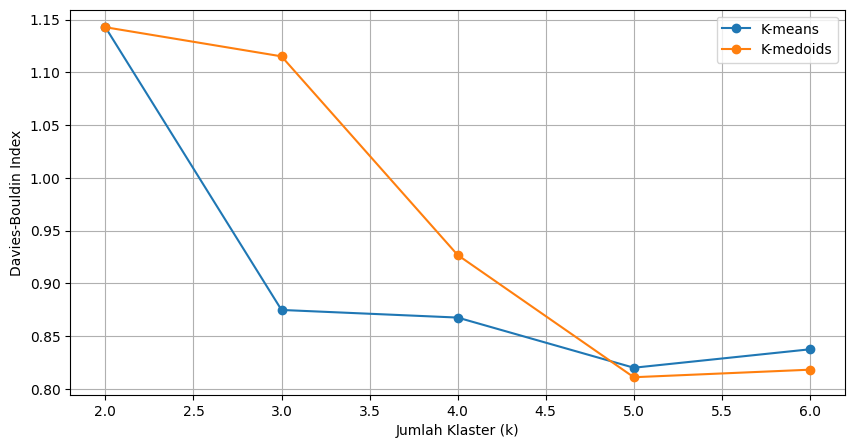

In [12]:
# Initialize lists to store Davies-Bouldin scores and centroids/medoids
kmeans_scores = []
kmedoids_scores = []
kmeans_initial_centroids_list = []
kmeans_final_centroids_list = []
kmedoids_initial_medoids_list = []
kmedoids_final_medoids_list = []

# Store the best models
best_kmeans = None
best_kmedoids = None
best_kmeans_score = float('inf')
best_kmedoids_score = float('inf')
best_kmeans_initial_centroids = None
best_kmeans_final_centroids = None
best_kmedoids_initial_medoids = None
best_kmedoids_final_medoids = None

# Helper function to manually initialize centroids/medoids
def initialize_centroids(X, k, seed=None):
    if seed is not None:
        np.random.seed(seed)
    indices = np.random.choice(X.shape[0], k, replace=False)
    return X[indices]

# Iterate over the number of clusters from 2 to 6
for n_clusters in range(2, 7):
    # Initialize centroids/medoids outside the clustering method
    initial_centroids = initialize_centroids(X, n_clusters, seed=0)
    
    # K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, init=initial_centroids, n_init=1, random_state=0)
    kmeans.fit(X)
    
    kmeans_initial_centroids = initial_centroids  # Capture initial centroids
    kmeans_final_centroids = kmeans.cluster_centers_
    kmeans_labels = kmeans.labels_
    
    # Store the initial and final centroids for K-means
    kmeans_initial_centroids_list.append(kmeans_initial_centroids)
    kmeans_final_centroids_list.append(kmeans_final_centroids)
    
    # Calculate Davies-Bouldin Index for K-means
    try:
        kmeans_db_score = davies_bouldin_score(X, kmeans_labels)
    except:
        kmeans_db_score = float('inf')
    
    kmeans_scores.append(kmeans_db_score)
    
    if kmeans_db_score < best_kmeans_score:
        best_kmeans_score = kmeans_db_score
        best_kmeans = (n_clusters, kmeans, kmeans_labels)
        best_kmeans_labels = kmeans_labels
        best_kmeans_initial_centroids = kmeans_initial_centroids
        best_kmeans_final_centroids = kmeans_final_centroids
    
    # K-medoids clustering
    kmedoids = KMedoids(n_clusters=n_clusters, init=initial_centroids, random_state=0)
    kmedoids.fit(X)
    
    kmedoids_initial_medoids = initial_centroids  # Capture initial medoids
    kmedoids_final_medoids = kmedoids.cluster_centers_
    kmedoids_labels = kmedoids.labels_
    
    # Store the initial and final medoids for K-medoids
    kmedoids_initial_medoids_list.append(kmedoids_initial_medoids)
    kmedoids_final_medoids_list.append(kmedoids_final_medoids)
    
    # Calculate Davies-Bouldin Index for K-medoids
    try:
        kmedoids_db_score = davies_bouldin_score(X, kmedoids_labels)
    except:
        kmedoids_db_score = float('inf')
    
    kmedoids_scores.append(kmedoids_db_score)
    
    if kmedoids_db_score < best_kmedoids_score:
        best_kmedoids_score = kmedoids_db_score
        best_kmedoids = (n_clusters, kmedoids, kmedoids_labels)
        best_kmedoids_labels = kmedoids_labels
        best_kmedoids_initial_medoids = kmedoids_initial_medoids
        best_kmedoids_final_medoids = kmedoids_final_medoids

# Plot the Davies-Bouldin scores for both methods
plt.figure(figsize=(10, 5))
plt.plot(range(2, 7), kmeans_scores, label='K-means', marker='o')
plt.plot(range(2, 7), kmedoids_scores, label='K-medoids', marker='o')
plt.xlabel('Jumlah Klaster (k)')
plt.ylabel('Davies-Bouldin Index')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
cluster_summary = datadf
cluster_summary['y'] = data_y
cluster_summary['kmeans'] = best_kmeans_labels
cluster_summary['kmedoids'] = best_kmedoids_labels 
#cluster_summary.to_excel('cluster_summary.xlsx')

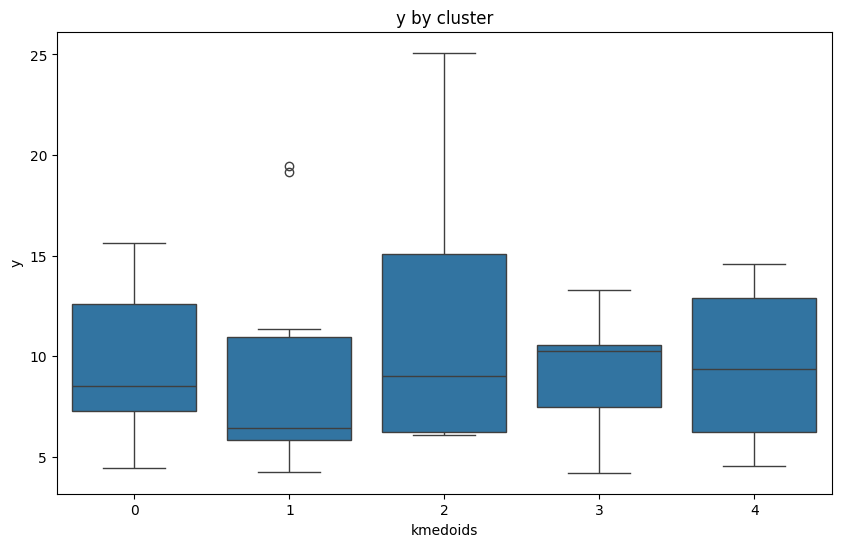

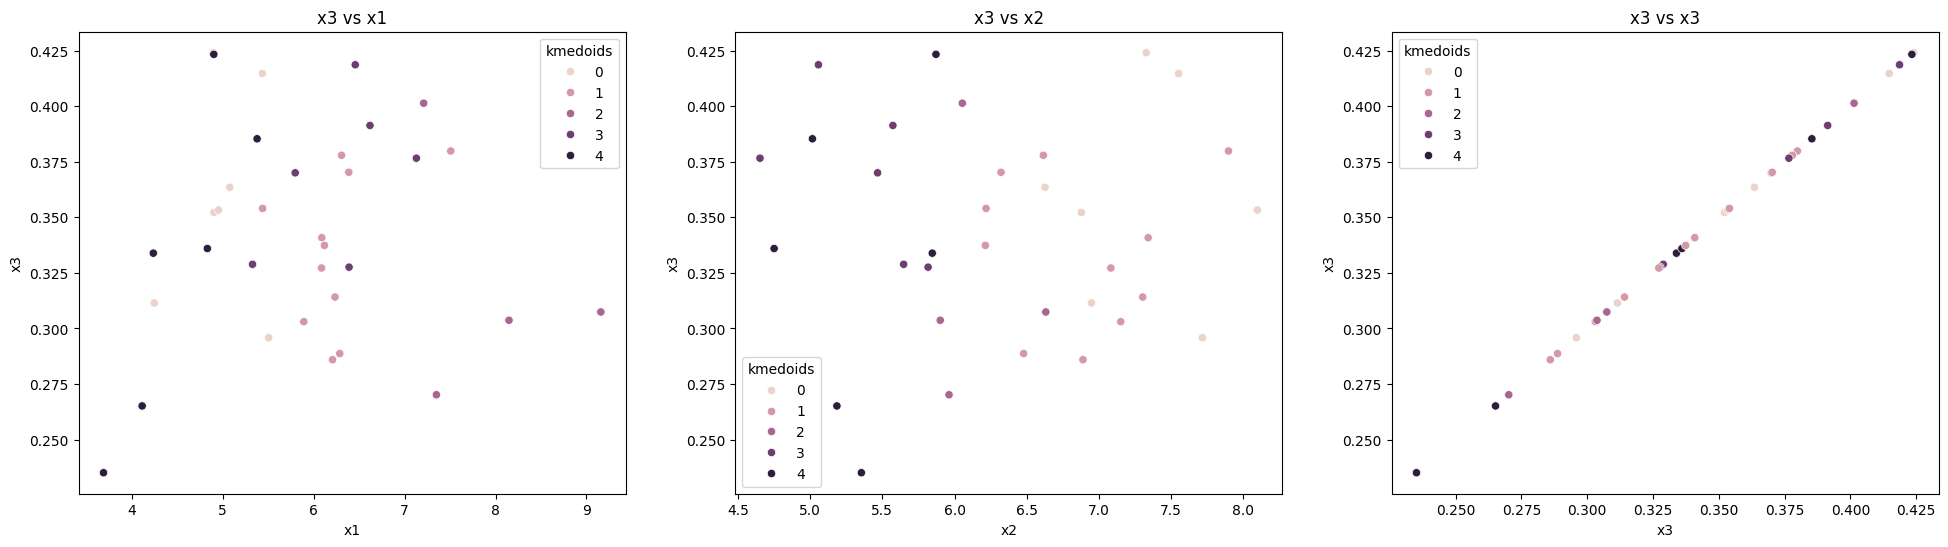

In [32]:
# Data Preparation
data_check = cluster_summary
cluster_methods = 'kmedoids'
# Summary Statistics
x1_stats = data_check.groupby(cluster_methods)['x1'].agg(['mean'])
x2_stats = data_check.groupby(cluster_methods)['x2'].agg(['mean'])
x3_stats = data_check.groupby(cluster_methods)['x3'].agg(['mean'])
# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=cluster_methods, y='y', data=data_check)
plt.title('y by cluster')
plt.show()

# Scatter Plots
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

variables = ['x1', 'x2', 'x3']
for i, var in enumerate(variables):
    sns.scatterplot(x=var, y='x3', hue=cluster_methods, data=data_check, ax=axes[i])
    axes[i].set_title(f'x3 vs {var}')

plt.show()

Shapiro-Wilk test for x1: Statistics=0.9721938371658325, p=0.5245236754417419


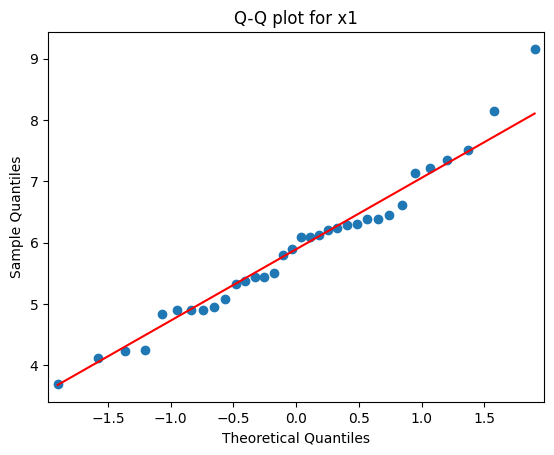

Shapiro-Wilk test for x2: Statistics=0.9791983962059021, p=0.7473809123039246


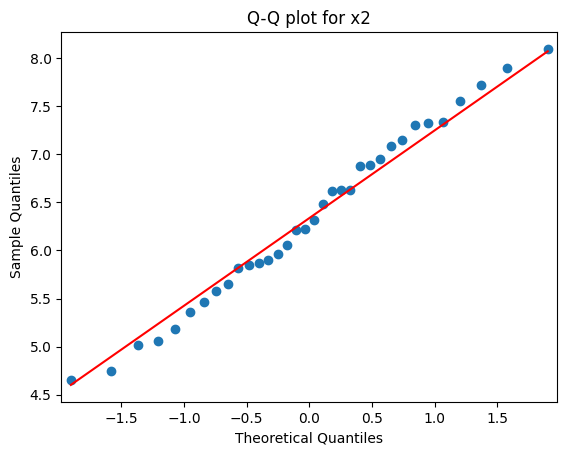

Shapiro-Wilk test for x3: Statistics=0.9814596772193909, p=0.8175498247146606


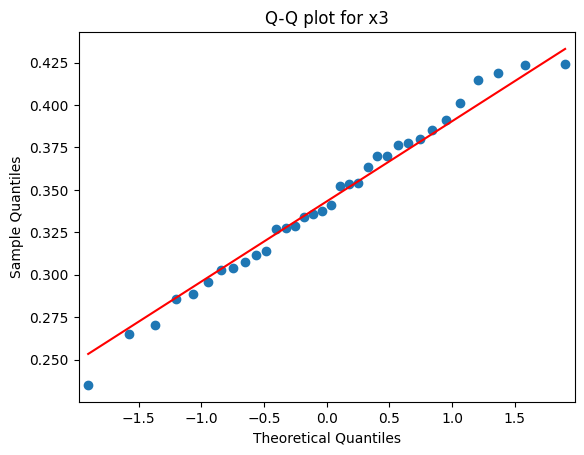

Multivariate normality test results:
HZResults(hz=0.5666960164804158, pval=0.6260174650652894, normal=True)
Box's M Test Results:
df: box    24.0
Name: df, dtype: float64
Chi-square: box    28.721069
Name: Chi2, dtype: float64
p-value: box    0.230805
Name: pval, dtype: float64


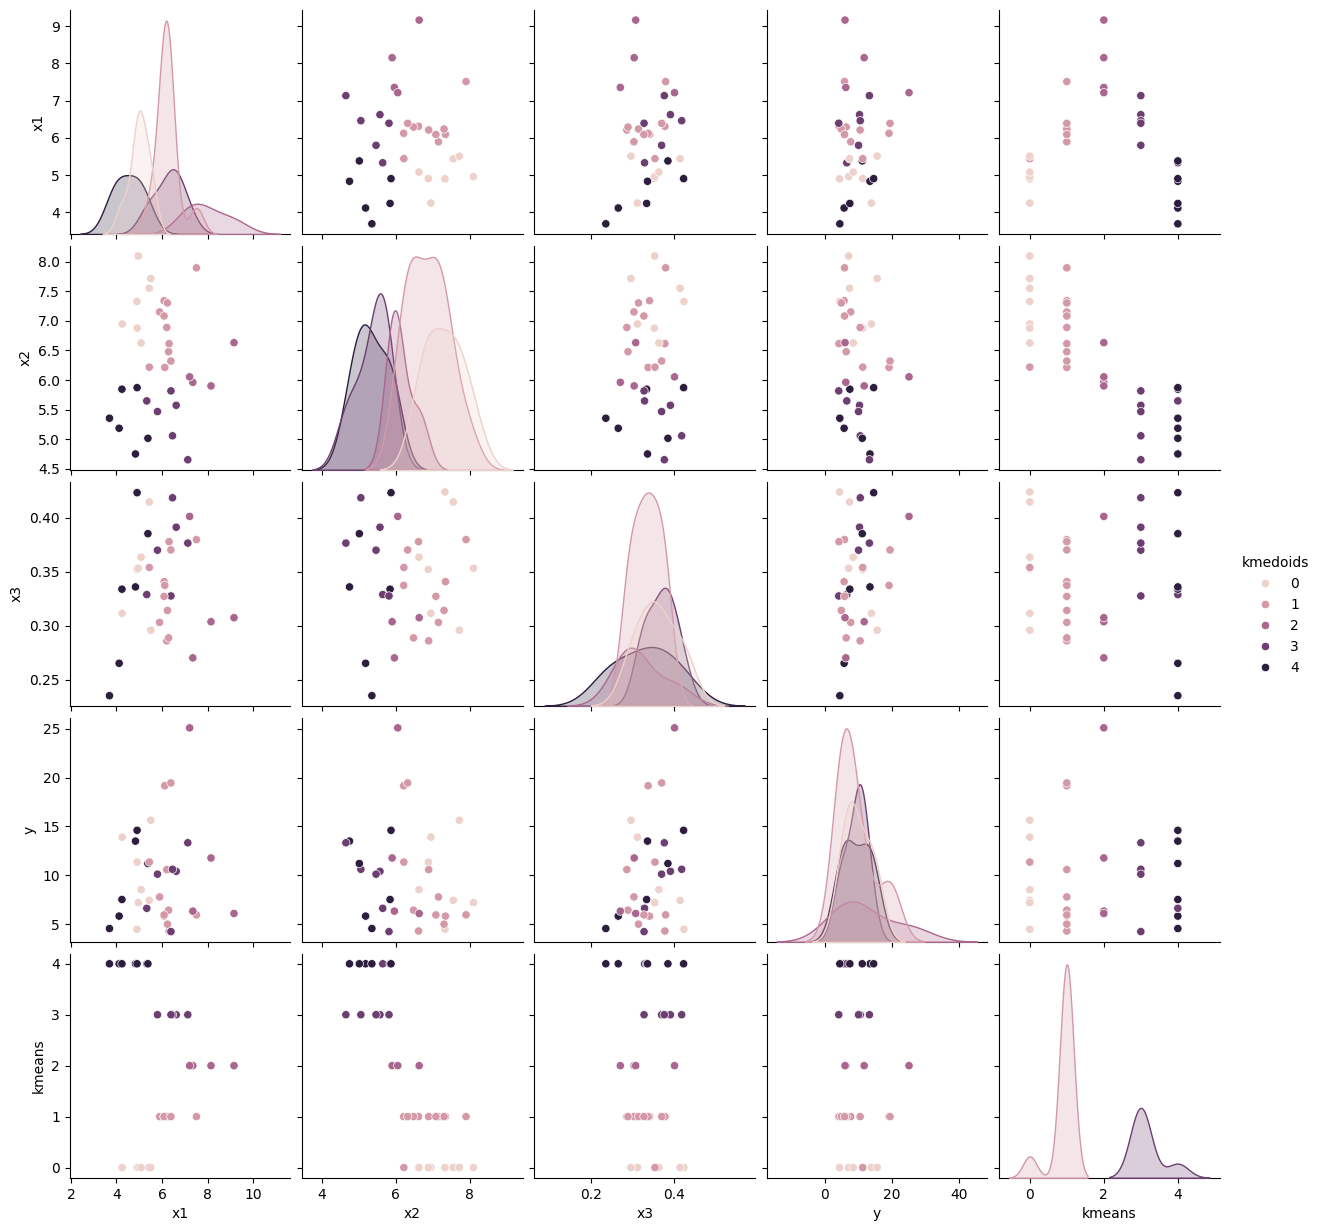

  feature        VIF
0      x1  22.861176
1      x2  30.829611
2      x3  32.336931
                   Multivariate linear model
                                                                
----------------------------------------------------------------
       Intercept         Value   Num DF  Den DF  F Value  Pr > F
----------------------------------------------------------------
          Wilks' lambda   0.0076 3.0000 30.0000 1304.6597 0.0000
         Pillai's trace   0.9924 3.0000 30.0000 1304.6597 0.0000
 Hotelling-Lawley trace 130.4660 3.0000 30.0000 1304.6597 0.0000
    Roy's greatest root 130.4660 3.0000 30.0000 1304.6597 0.0000
----------------------------------------------------------------
                                                                
----------------------------------------------------------------
            kmedoids        Value  Num DF  Den DF F Value Pr > F
----------------------------------------------------------------
              Wilks' lambd

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro, normaltest
from statsmodels.graphics.gofplots import qqplot
from pingouin import multivariate_normality
import pingouin
from bioinfokit.analys import stat as bs
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Univariate Normality Check
for col in ['x1', 'x2', 'x3']:
    stat, p = shapiro(data_check[col])
    print(f'Shapiro-Wilk test for {col}: Statistics={stat}, p={p}')
    qqplot(data_check[col], line='s')
    plt.title(f'Q-Q plot for {col}')
    plt.show()

# Multivariate Normality Check
data_multivariate = data_check[['x1', 'x2', 'x3']]
multivariate_test_result = multivariate_normality(data_multivariate, alpha=0.05)
print(f'Multivariate normality test results:\n{multivariate_test_result}')

# Homogeneity of Covariance Matrices (Box's M test)
box_test = pingouin.box_m(data=data_check, dvs=['x1', 'x2', 'x3'], group='kmedoids')
print("Box's M Test Results:")
print(f'df: {box_test.df}')
print(f'Chi-square: {box_test.Chi2}')
print(f'p-value: {box_test.pval}')

# Linearity (Scatterplot Matrix)
sns.pairplot(data_check, hue='kmedoids')
plt.show()

# Absence of Multicollinearity (VIF)
X_vif = data_check[['x1', 'x2', 'x3']]
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]
print(vif_data)

# Perform MANOVA
dependent_vars = ['x1', 'x2', 'x3']
dependent_vars_str = ' + '.join(dependent_vars)
formula = f'{dependent_vars_str} ~ {cluster_methods}'
manova = MANOVA.from_formula(formula, data=data_check)
print(manova.mv_test())
